In [1]:
from misid_model import *
from scipy.optimize import minimize
import numdifftools as nd
from utility_commonPlot import *

# 1. Perform Template Fit

In [2]:
baseDir = common.getBaseDirectory()
X = np.load(baseDir + "data/misidtemplates/shaping/X_.npy")
Y = np.load(baseDir + "data/misidtemplates/shaping/Y_.npy")
model = PredictiveModel(X)

In [8]:
def loss (param):
    param = np.r_[param[0],param]
    y = model.predict(param)
    loss  = np.sum( (y-Y)**2/(2*Y) )
    loss += np.sum( (param[2:]**2)/2  )
    return loss

param0 = np.array([1]*1 + [0]*10)
result = minimize( loss, param0, method='SLSQP', bounds = [(0,2)]*1 + [(-5,5)]*10 )

[ 0.75752079  0.25901101  0.11550493  0.38575353 -0.10023962  1.57480066
  1.09293095  3.53546089  0.42769656  2.58211762  0.        ] [0.02412242 0.99605925 0.99956459 0.97046272 0.3974633  0.47202356
 0.97544541 0.86603855 0.7065432  0.70858737 1.00000031]


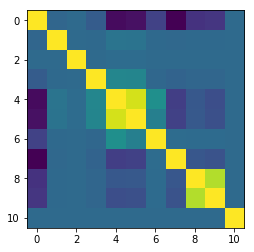

In [9]:
hcalc = nd.Hessian(loss, step=1e-4, method='central')
hess  = hcalc( result.x )
hessinv = np.linalg.inv(hess)
sig   = np.sqrt(hessinv.diagonal())
cor   = hessinv/np.outer(sig, sig)
loss0 = loss(result.x)

print(result.x,sig)
imshow(cor)

# 2. Plot Post-fit Templates

In [10]:
temp = np.concatenate(model.predict(result.x,True),axis=1)
targ = np.concatenate(Y,axis=0)
# separate processes
mctt = np.sum(temp[0:4],axis=0)
mct  = np.sum(temp[4:8],axis=0)
mcw  = np.sum(temp[8:12],axis=0)
mcz  = np.sum(temp[12:16],axis=0)
mcvv = np.sum(temp[16:20],axis=0)

mclist = [mcvv,mcz,mcw,mct,mctt]

Text(0.5,0,'$p^T_\\tau$ [GeV], each channel range 20-80 GeV')

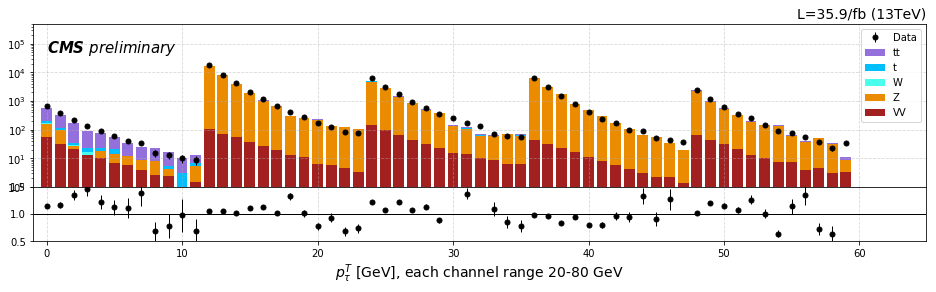

In [11]:
colorList = ["#a32020","#eb8c00","#49feec","deepskyblue","mediumpurple"]
labelList = ["VV","Z","W","t","tt"]
chList = common.channelLsit()


fig, axes = plt.subplots(2, 1, sharex=True, facecolor='w',
                         gridspec_kw={'height_ratios':[3,1]},
                         figsize=(16,4))
fig.subplots_adjust(hspace=0)


c = np.arange(targ.size)
accum = np.zeros(targ.size)

# making plot

ax = axes[0]
for i in range(len(mclist)):
    height = mclist[i]
    ax.bar(c, height, bottom=accum, width=0.8, alpha=1, color=colorList[i],label=labelList[i])
    accum += height
ax.errorbar(c, targ,yerr=targ**0.5, c='k', fmt='.',markersize=10,lw=1, label='Data')
ax.grid(True,linestyle="--",alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
ax.set_yscale('log')
ax.set_ylim(1,5e5)
ax.text(0, 5e4, r'CMS $preliminary$',style="italic",fontsize="15",fontweight='bold')
ax.set_title("L=35.9/fb (13TeV)",loc="right",fontsize=14)

ax = axes[1]
ax.errorbar(c, targ/accum, yerr=targ**0.5/accum, c='k', fmt='.',markersize=10,lw=1)
ax.grid(True,linestyle="--",alpha=0.5)
ax.axhline(1,lw=1,color='k')
ax.set_ylim(0.5,1.5)
ax.set_xlim(c.min()-1., 1.1*c.max())
ax.set_xlabel(r'$p^T_\tau$ [GeV], each channel range 20-80 GeV',fontsize=14)

#plt.savefig('../../plots/tauID',dpi=300)